# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [55]:
# Import required libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score ,f1_score,classification_report, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns



In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Explore the data

<AxesSubplot:>

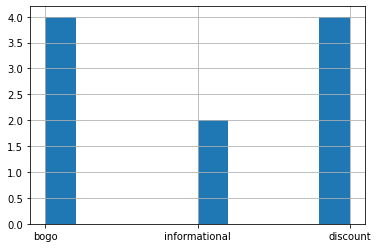

In [4]:
#portfolio dataset offer_type
portfolio.offer_type.hist()

<AxesSubplot:>

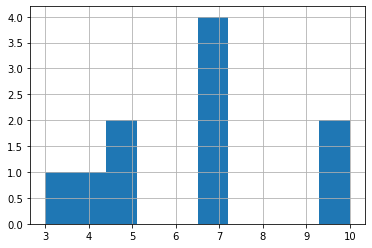

In [7]:
#portfolio dataset duration
portfolio.duration.hist()

<AxesSubplot:>

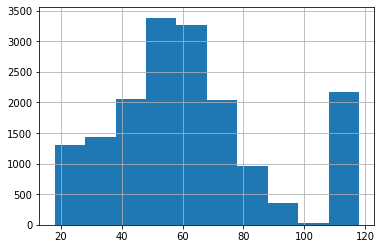

In [8]:
#profile dataset age
profile.age.hist()

<AxesSubplot:>

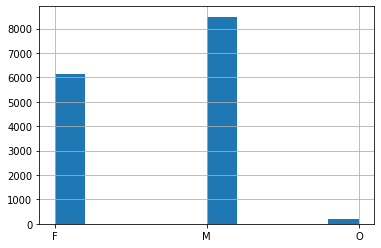

In [9]:
#profile dataset gender
profile.gender.hist()

<AxesSubplot:>

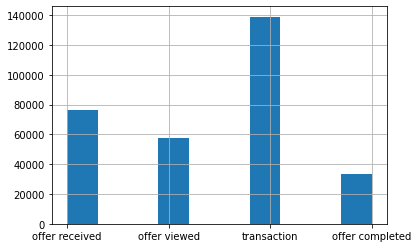

In [10]:
#transcript dataset event
transcript.event.hist()

#  Data Cleaning

## Cleaning Portfolio

In [3]:
new_cols_name = {'difficulty':'offer_difficulty' , 'id':'offer_id', 'duration':'offer_duration', 'reward': 'offer_reward'}
cleaned_portfolio = portfolio.rename(columns =  new_cols_name )

In [6]:
cleaned_portfolio.head(10)

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


## Cleaning Profile

In [4]:
cols_profile = {'id':'customer_id' , 'income':'customer_income'}
cleaned_profile = profile.rename(columns =  cols_profile )

In [5]:
cleaned_profile.replace(118, np.nan , inplace=True)
cleaned_profile['age'] = cleaned_profile['age'].fillna(cleaned_profile['age'].mean())
cleaned_profile['customer_income'] = cleaned_profile['customer_income'].fillna(cleaned_profile['customer_income'].mean())
mode = cleaned_profile['gender'].mode()[0]
cleaned_profile['gender'] = cleaned_profile['gender'].fillna(mode)
cleaned_profile = cleaned_profile[cleaned_profile['age'] <= 80]
cleaned_profile['age'] = cleaned_profile['age'].astype(int)

cleaned_profile.loc[(cleaned_profile.age < 20) , 'Age_group'] = 'Under 20'
cleaned_profile.loc[(cleaned_profile.age >= 20) & (cleaned_profile.age <= 45) , 'Age_group'] = '20-45'
cleaned_profile.loc[(cleaned_profile.age >= 46) & (cleaned_profile.age <= 60) , 'Age_group'] = '46-60'
cleaned_profile.loc[(cleaned_profile.age >= 61) , 'Age_group'] = '61-80'
cleaned_profile.drop('age',axis=1,inplace=True)


In [9]:
cleaned_profile.head(10)

,gender,customer_id,became_member_on,customer_income,Age_group
0,M,68be06ca386d4c31939f3a4f0e3dd783,20170212,65404.991568,46-60
1,F,0610b486422d4921ae7d2bf64640c50b,20170715,112000.000000,46-60
2,M,38fe809add3b4fcf9315a9694bb96ff5,20180712,65404.991568,46-60
3,F,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.000000,61-80
4,M,a03223e636434f42ac4c3df47e8bac43,20170804,65404.991568,46-60
5,M,e2127556f4f64592b11af22de27a7932,20180426,70000.000000,61-80
6,M,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,65404.991568,46-60
7,M,68617ca6246f4fbc85e91a2a49552598,20171002,65404.991568,46-60
8,M,389bc3fa690240e798340f5a15918d5c,20180209,53000.000000,61-80
9,M,8974fc5686fe429db53ddde067b88302,20161122,65404.991568,46-60


##  Cleaning Transcript

In [7]:
transcript_cols = {'person':'customer_id'}
cleaned_transcript = transcript.rename(columns =  transcript_cols)

In [8]:
cleaned_transcript['offer_id'] = cleaned_transcript['value'].apply(lambda x: x.get('offer_id'))
cleaned_transcript['offer id'] = cleaned_transcript['value'].apply(lambda x: x.get('offer id'))
cleaned_transcript['money_gained'] = cleaned_transcript['value'].apply(lambda x: x.get('reward'))
cleaned_transcript['money_spent'] = cleaned_transcript['value'].apply(lambda x: x.get('amount'))

cleaned_transcript['offer_id'] = cleaned_transcript.apply(lambda x : x['offer id'] if x['offer_id'] == None else x['offer_id'], axis=1)
cleaned_transcript.drop(['offer id' , 'value'] , axis=1, inplace=True)
cleaned_transcript.fillna(0 , inplace=True)
    


In [12]:
cleaned_transcript.head(10)

,customer_id,event,time,offer_id,money_gained,money_spent
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0
5,389bc3fa690240e798340f5a15918d5c,offer received,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,0.0
6,c4863c7985cf408faee930f111475da3,offer received,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.0,0.0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,0,3f207df678b143eea3cee63160fa8bed,0.0,0.0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
9,31dda685af34476cad5bc968bdb01c53,offer received,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0


# Exploratory Data Analysis

## Merging data frames 

In [9]:
merged_df = pd.merge(cleaned_portfolio, cleaned_transcript, on='offer_id')
merged_df = pd.merge(merged_df, cleaned_profile, on='customer_id')

In [9]:
merged_df.head(10)

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80
5,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,4b0da7e80e5945209a1fdddfe813dbe0,offer received,408,0.0,0.0,M,20170909,100000.0,61-80
6,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,468,0.0,0.0,M,20170909,100000.0,61-80
7,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,offer received,168,0.0,0.0,M,20170909,100000.0,61-80
8,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,174,0.0,0.0,M,20170909,100000.0,61-80
9,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,180,5.0,0.0,M,20170909,100000.0,61-80


### now the data is combined and ready for Exploratory Data Analysis.

In [21]:
print('Average income of customers using the app is {}'.format(round(merged_df['customer_income'].mean(),2)))

Average income of customers using the app is 65924.49


Most used offer is:


<AxesSubplot:title={'center':' Dist of offer types'}>

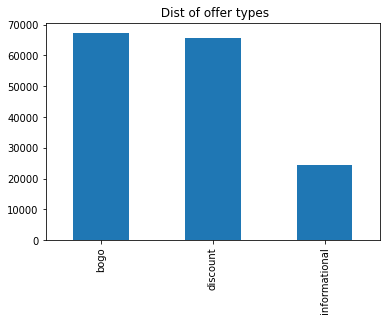

In [22]:
print('Most used offer is:')
merged_df['offer_type'].value_counts().plot.bar(title=' Dist of offer types')

 Distribution of age is


<AxesSubplot:title={'center':' Dist of age'}>

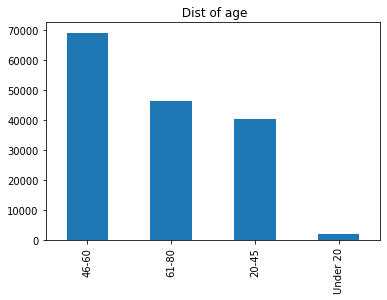

In [23]:
print(' Distribution of age is')
merged_df['Age_group'].value_counts().plot.bar(title=' Dist of age')

 Distribution of offers


<AxesSubplot:title={'center':' Dist of offers'}>

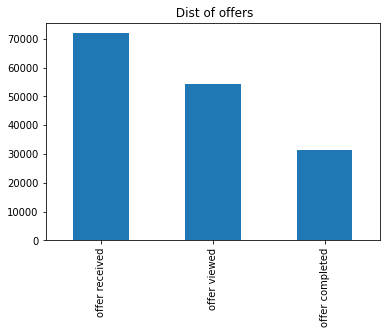

In [24]:
print(' Distribution of offers')
merged_df['event'].value_counts().plot.bar(title=' Dist of offers')

In [ ]:
plot_gender = merged_df[merged_df['gender'] != 'O']

Distribution of males and females


<AxesSubplot:title={'center':'Dist of males and females'}>

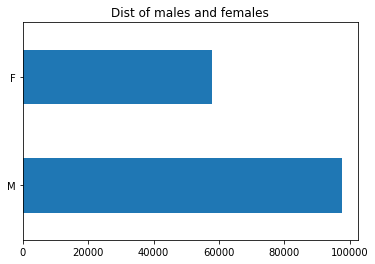

In [ ]:
print('Distribution of males and females')
plot_gender.gender.value_counts().plot.barh(title = 'Dist of males and females')

Age group of males and females is:


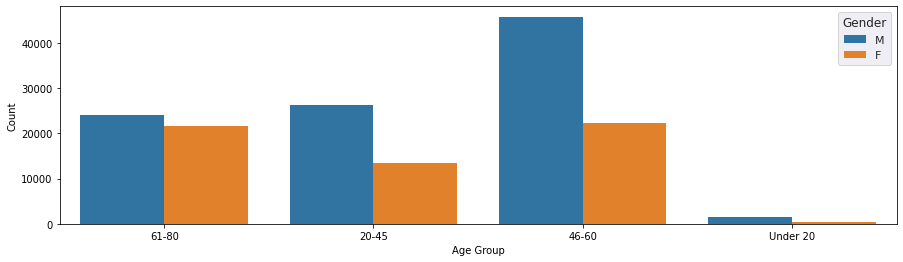

In [ ]:
print('Age group of males and females is:')
plt.figure(figsize=(15, 4))
sns.countplot(x= "Age_group", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

Gender distribution in each offer type is:


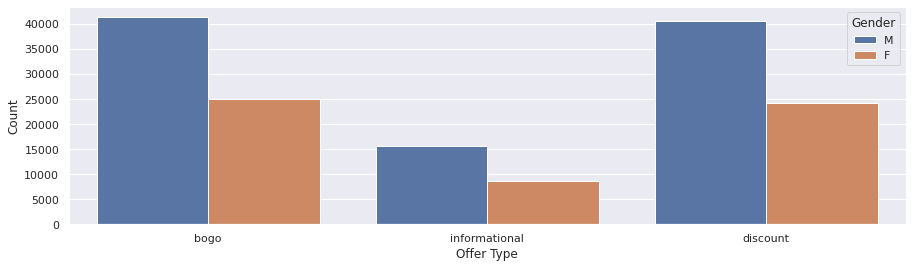

In [ ]:
print('Gender distribution in each offer type is:')
plt.figure(figsize=(15, 4))
sns.countplot(x= "offer_type", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.ylabel('Count')
plt.xlabel('Offer Type')
plt.legend(title='Gender')

Gender distribution is:


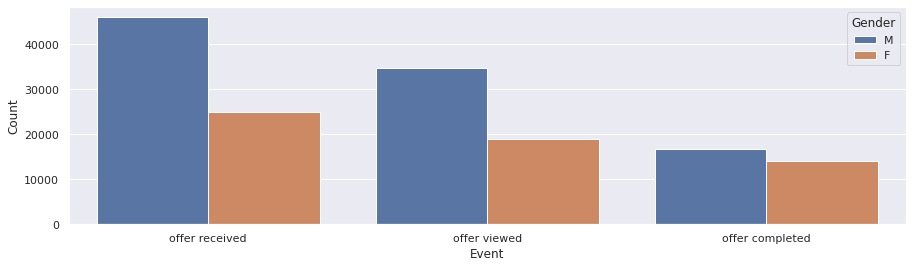

In [ ]:
print('Gender distribution is:')
plt.figure(figsize=(15, 4))
sns.countplot(x= "event", hue= "gender", data=plot_gender)
sns.set(style="darkgrid")
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Gender')

Distribution of offer types in events


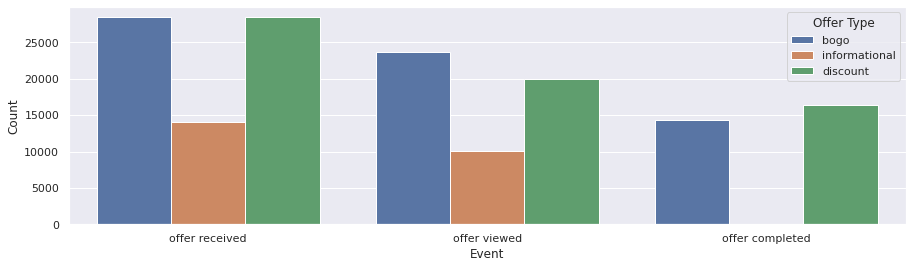

In [ ]:
print('Distribution of offer types in events')
plt.figure(figsize=(15, 4))
sns.countplot(x= "event", hue= "offer_type", data=plot_gender)
sns.set(style="darkgrid")
plt.ylabel('Count')
plt.xlabel('Event')
plt.legend(title='Offer Type')

Age distribution in events


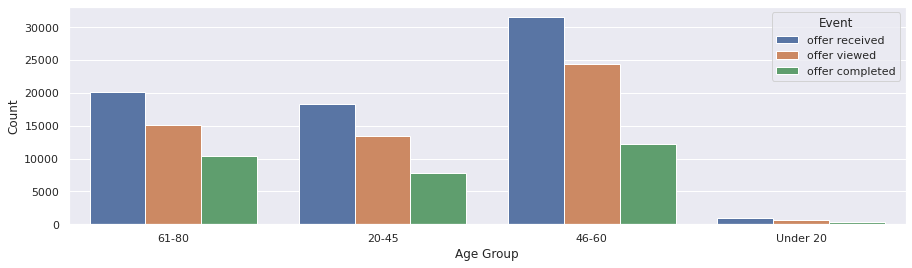

In [ ]:
print('Age distribution in events')
plt.figure(figsize=(15, 4))
sns.countplot(x= "Age_group", hue= "event", data=plot_gender)
sns.set(style="darkgrid")
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Event')

# create a ML model for predict response of a customer to the offer

## Data Preprocessing 

In [ ]:
merged_df.head(10)

,offer_reward,channels,offer_difficulty,offer_duration,offer_type,offer_id,customer_id,event,time,money_gained,money_spent,gender,became_member_on,customer_income,Age_group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,20170909,100000.0,61-80
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,20170909,100000.0,61-80
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,20170909,100000.0,61-80
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,20170909,100000.0,61-80
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,20170909,100000.0,61-80
5,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,4b0da7e80e5945209a1fdddfe813dbe0,offer received,408,0.0,0.0,M,20170909,100000.0,61-80
6,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,468,0.0,0.0,M,20170909,100000.0,61-80
7,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,offer received,168,0.0,0.0,M,20170909,100000.0,61-80
8,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,174,0.0,0.0,M,20170909,100000.0,61-80
9,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,180,5.0,0.0,M,20170909,100000.0,61-80


In [10]:
categorical = ['offer_type', 'gender', 'Age_group']
merged_df = pd.get_dummies(merged_df, columns = categorical)
merged_df = merged_df.drop('channels', 1).join(merged_df.channels.str.join('|').str.get_dummies())

merged_df['became_member_on'] = merged_df['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
merged_df['month_member'] = merged_df['became_member_on'].apply(lambda x: x.day)
merged_df['year_member'] = merged_df['became_member_on'].apply(lambda x: x.year)
merged_df.drop('became_member_on',axis=1, inplace=True)    

offerids = merged_df['offer_id'].unique().tolist()
o_mapping = dict( zip(offerids,range(len(offerids))) )
merged_df.replace({'offer_id': o_mapping},inplace=True)

cusids = merged_df['customer_id'].unique().tolist()
c_mapping = dict( zip(cusids,range(len(cusids))) )
merged_df.replace({'customer_id': c_mapping},inplace=True)

scaler = StandardScaler() 
numerical = ['customer_income', 'offer_difficulty', 'offer_duration', 'offer_reward', 'time', 'money_gained', 'money_spent']
merged_df[numerical] = scaler.fit_transform(merged_df[numerical])

merged_df['event'] = merged_df['event'].map({'offer received':1, 'offer viewed':2, 'offer completed':3})
    

In [14]:
merged_df.head(10)

,offer_reward,offer_difficulty,offer_duration,offer_id,customer_id,event,time,money_gained,money_spent,customer_income,offer_type_bogo,offer_type_discount,offer_type_informational,gender_F,gender_M,gender_O,Age_group_20-45,Age_group_46-60,Age_group_61-80,Age_group_Under 20,email,mobile,social,web,month_member,year_member
0,1.655187,0.424965,0.181176,0,0,1,-1.782871,-0.415669,0.0,1.697973,1,0,0,0,1,0,0,0,1,0,1,1,1,0,9,2017
1,1.655187,0.424965,0.181176,0,0,2,-1.268524,-0.415669,0.0,1.697973,1,0,0,0,1,0,0,0,1,0,1,1,1,0,9,2017
2,1.655187,0.424965,0.181176,0,0,1,0.758608,-0.415669,0.0,1.697973,1,0,0,0,1,0,0,0,1,0,1,1,1,0,9,2017
3,1.655187,0.424965,0.181176,0,0,2,0.788864,-0.415669,0.0,1.697973,1,0,0,0,1,0,0,0,1,0,1,1,1,0,9,2017
4,1.655187,0.424965,0.181176,0,0,3,0.788864,3.865849,0.0,1.697973,1,0,0,0,1,0,0,0,1,0,1,1,1,0,9,2017
5,-1.310456,-1.554745,-1.222749,1,0,1,0.274517,-0.415669,0.0,1.697973,0,0,1,0,1,0,0,0,1,0,1,1,0,1,9,2017
6,-1.310456,-1.554745,-1.222749,1,0,2,0.577074,-0.415669,0.0,1.697973,0,0,1,0,1,0,0,0,1,0,1,1,0,1,9,2017
7,0.172366,2.404675,1.585101,2,0,1,-0.935712,-0.415669,0.0,1.697973,0,1,0,0,1,0,0,0,1,0,1,0,0,1,9,2017
8,0.172366,2.404675,1.585101,2,0,2,-0.905456,-0.415669,0.0,1.697973,0,1,0,0,1,0,0,0,1,0,1,0,0,1,9,2017
9,0.172366,2.404675,1.585101,2,0,3,-0.875200,1.725090,0.0,1.697973,0,1,0,0,1,0,0,0,1,0,1,0,0,1,9,2017


## Split train and test data

In [14]:
data = merged_df.drop('event', axis=1)
label = merged_df['event']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size = 0.3, random_state = 42)

print("Training set shape: {} ".format(X_train.shape))
print("Testing set shape: {} ".format(X_test.shape))

Training set shape: (110252, 25) 
Testing set shape: (47251, 25) 


## Training and Testing

### KNN 3

In [66]:
clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
knn3_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
knn3_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
knn3_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
knn3_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

              precision    recall  f1-score   support

           1       0.35      0.50      0.41     21668
           2       0.13      0.11      0.12     16158
           3       0.49      0.14      0.22      9425

    accuracy                           0.30     47251
   macro avg       0.32      0.25      0.25     47251
weighted avg       0.30      0.30      0.27     47251



### KNN 5

In [67]:
clf = KNeighborsClassifier(n_neighbors = 5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
knn5_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
knn5_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
knn5_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
knn5_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

              precision    recall  f1-score   support

           1       0.38      0.57      0.46     21668
           2       0.16      0.13      0.15     16158
           3       0.60      0.09      0.16      9425

    accuracy                           0.33     47251
   macro avg       0.38      0.27      0.26     47251
weighted avg       0.35      0.33      0.29     47251



### KNN 7

In [68]:
clf = KNeighborsClassifier(n_neighbors = 7)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
knn7_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
knn7_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
knn7_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
knn7_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

              precision    recall  f1-score   support

           1       0.40      0.59      0.48     21668
           2       0.17      0.13      0.15     16158
           3       0.47      0.15      0.23      9425

    accuracy                           0.35     47251
   macro avg       0.35      0.29      0.28     47251
weighted avg       0.34      0.35      0.32     47251



### RandomForestClassifier

In [16]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
rf_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
rf_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
rf_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
rf_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

              precision    recall  f1-score   support

           1       0.67      0.72      0.70     21668
           2       0.59      0.53      0.56     16158
           3       1.00      1.00      1.00      9425

    accuracy                           0.71     47251
   macro avg       0.75      0.75      0.75     47251
weighted avg       0.71      0.71      0.71     47251



### RandomForestClassifie 

In [60]:
from sklearn.metrics import make_scorer
parameters = {
    'max_features' : ['auto', 'sqrt'],
    'n_estimators': [50,100,200],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap' : [True, False]
    }


clf = GridSearchCV(RandomForestClassifier(), parameters,refit=False,cv=2)
clf.fit(X_train, y_train)


print('best parametrs:')
print((clf.best_params_))


best parametrs:
{'bootstrap': True, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200}


In [61]:
scoring = ['precision_macro', 'recall_macro','F1_macro']
clf = RandomForestClassifier(n_estimators=200,min_samples_split=5,min_samples_leaf=4,max_features='sqrt',bootstrap=True)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
rf_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
rf_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
rf_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
rf_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

              precision    recall  f1-score   support

           1       0.74      0.89      0.80     21668
           2       0.79      0.57      0.66     16158
           3       1.00      1.00      1.00      9425

    accuracy                           0.80     47251
   macro avg       0.84      0.82      0.82     47251
weighted avg       0.81      0.80      0.79     47251



### DecisionTreeClassifier

In [48]:
from sklearn.metrics import make_scorer
parameters = {
    'criterion' : ['gini', 'entropy'],
    'max_depth' : [2,4,6,8,10,12]
    }


clf = GridSearchCV(DecisionTreeClassifier(), parameters,refit=False,cv=2)
clf.fit(X_train, y_train)


print('best parametrs:')
print((clf.best_params_))


best parametrs:
{'criterion': 'entropy', 'max_depth': 12}


In [62]:
clf = DecisionTreeClassifier(criterion = 'entropy',max_depth=12)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
Dt_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
Dt_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
Dt_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
Dt_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

              precision    recall  f1-score   support

           1       0.86      1.00      0.92     21668
           2       0.99      0.78      0.88     16158
           3       1.00      1.00      1.00      9425

    accuracy                           0.92     47251
   macro avg       0.95      0.93      0.93     47251
weighted avg       0.93      0.92      0.92     47251



### GradientBoostingClassifier

In [70]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
GB_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
GB_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
GB_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
GB_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

              precision    recall  f1-score   support

           1       0.86      1.00      0.92     21668
           2       1.00      0.78      0.88     16158
           3       1.00      1.00      1.00      9425

    accuracy                           0.93     47251
   macro avg       0.95      0.93      0.93     47251
weighted avg       0.94      0.93      0.92     47251



### GradientBoostingClassifier 

In [21]:
clf = GradientBoostingClassifier()
scoring = ['precision_macro', 'recall_macro','f1_macro']
scores = cross_validate(clf, X_train, y_train, scoring=scoring)


In [26]:
print('5-fold for data:')
pd.DataFrame(scores)

5-fold for data:


,fit_time,score_time,test_precision_macro,test_recall_macro,test_f1_macro
0,36.422724,0.119264,0.952531,0.927345,0.933675
1,35.500723,0.120979,0.951219,0.924991,0.931425
2,35.614400,0.117129,0.952068,0.926507,0.932878
3,35.412069,0.115434,0.951509,0.925505,0.931919
4,35.277101,0.115847,0.951037,0.924740,0.931178


### XGBoostingClassifier

In [58]:
params = {
    # Parameters that we are going to tune.
    'max_depth':[2,4,6],
    'eta':[.2,.3,.4],
    'subsample': [1,2,3],

}
clf = GridSearchCV(XGBClassifier(), params,refit=False,cv=2)
clf.fit(X_train, y_train)


print('best parametrs:')
print((clf.best_params_))


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:26:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/aidin/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 2 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

  FitFailedWarning)
/home/aidin/.local/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
xgboost.core.XGBoostError: value 3 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

  FitFailedWarning)


[21:26:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:26:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [59]:
print((clf.best_params_))


{'eta': 0.2, 'max_depth': 2, 'subsample': 1}


In [63]:

clf = XGBClassifier(eta = 0.2,max_depth = 2,subsample = 1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
Xgb_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
Xgb_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
Xgb_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
Xgb_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:16:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           1       0.86      1.00      0.92     21668
           2       1.00      0.78      0.88     16158
           3       1.00      1.00      1.00      9425

    accuracy                           0.93     47251
   macro avg       0.95      0.93      0.93     47251
weighted avg       0.94      0.93      0.92     47251



### ensemble all models

In [64]:
from sklearn.ensemble import StackingClassifier

estimators = [
     ('rf', RandomForestClassifier(n_estimators=200,min_samples_split=5,min_samples_leaf=4,max_features='sqrt',bootstrap=True)),
     ('knn',KNeighborsClassifier(n_neighbors = 7)),
     ('Dt', DecisionTreeClassifier(criterion = 'entropy',max_depth=12)),
     ('GB', GradientBoostingClassifier()),
     ('XGB', XGBClassifier(max_depth = 2, 
                            eta =  0.2,
                              subsample=1))
]

clf = StackingClassifier(
     estimators=estimators)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_pred=y_pred,y_true=y_test))
All_presision = precision_score(y_pred=y_pred,y_true=y_test,average='macro')
All_recall = recall_score(y_pred=y_pred,y_true=y_test,average='macro')
All_f1 = f1_score(y_pred=y_pred,y_true=y_test,average='macro')
All_acc = accuracy_score(y_pred=y_pred,y_true=y_test)

/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.6/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:22:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:22:57] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:23:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/home/aidin/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           1       0.87      0.99      0.93     21668
           2       0.98      0.80      0.88     16158
           3       1.00      1.00      1.00      9425

    accuracy                           0.93     47251
   macro avg       0.95      0.93      0.94     47251
weighted avg       0.93      0.93      0.93     47251



##  evaluation and Results

In [71]:
models = { 'Presision_score':[knn3_presision, knn5_presision, knn7_presision,rf_presision,Dt_presision,GB_presision,Xgb_presision,All_presision], 
          'Recall_score': [knn3_recall, knn5_recall, knn7_recall,rf_recall,Dt_recall,GB_recall,Xgb_recall,All_recall],
         'F1_score':[knn3_f1, knn5_f1, knn7_f1,rf_f1,Dt_f1,GB_f1,Xgb_f1,All_f1],
         'accuracy':[knn3_acc, knn5_acc, knn7_acc,rf_acc,Dt_acc,GB_acc,Xgb_acc,All_acc]
         }
          
result = pd.DataFrame(models,index= ['KNN 3 Classifier','KNN 5 Classifier','KNN 7 Classifier','Random Forest Classifier','Decision Tree Classifier','GradientBoostingClassifier', 'XGBoostingClassifier','ensemble all models'])

In [72]:
result

,Presision_score,Recall_score,F1_score,accuracy
KNN 3 Classifier,0.323952,0.250381,0.249827,0.295422
KNN 5 Classifier,0.382531,0.266697,0.255408,0.327210
KNN 7 Classifier,0.347202,0.290630,0.284789,0.345284
Random Forest Classifier,0.841364,0.819556,0.822499,0.801507
Decision Tree Classifier,0.951339,0.926002,0.932687,0.923726
GradientBoostingClassifier,0.953155,0.926909,0.933762,0.925017
XGBoostingClassifier,0.953155,0.926909,0.933762,0.925017
ensemble all models,0.950600,0.929802,0.935760,0.926774


<AxesSubplot:title={'center':' Presision_score'}>

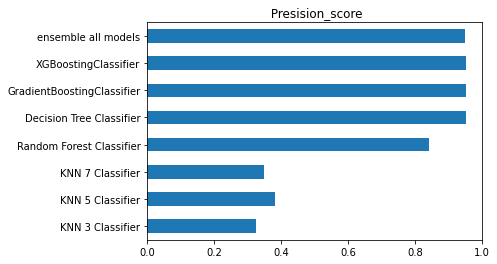

In [73]:
result['Presision_score'].plot.barh(title=' Presision_score')

<AxesSubplot:title={'center':' Recall_score'}>

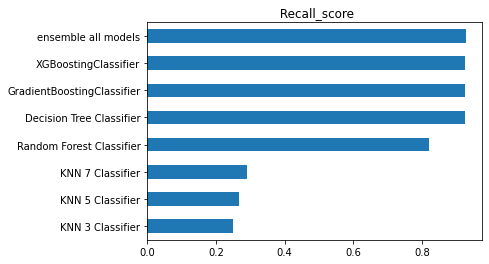

In [74]:
result['Recall_score'].plot.barh(title=' Recall_score')

<AxesSubplot:title={'center':' F1_score'}>

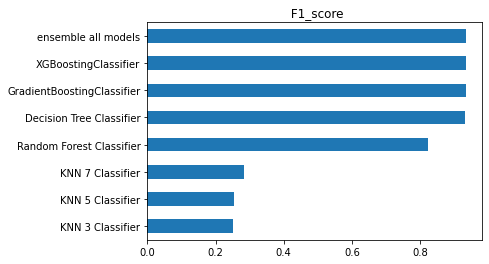

In [75]:
result['F1_score'].plot.barh(title=' F1_score')

<AxesSubplot:title={'center':' accuracy'}>

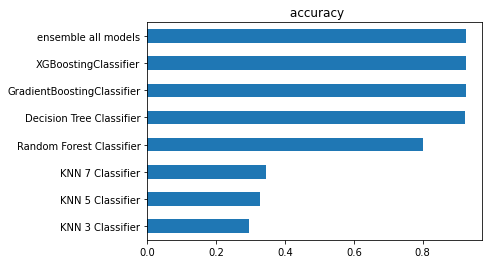

In [76]:
result['accuracy'].plot.barh(title=' accuracy')

<AxesSubplot:title={'center':'all of result'}>

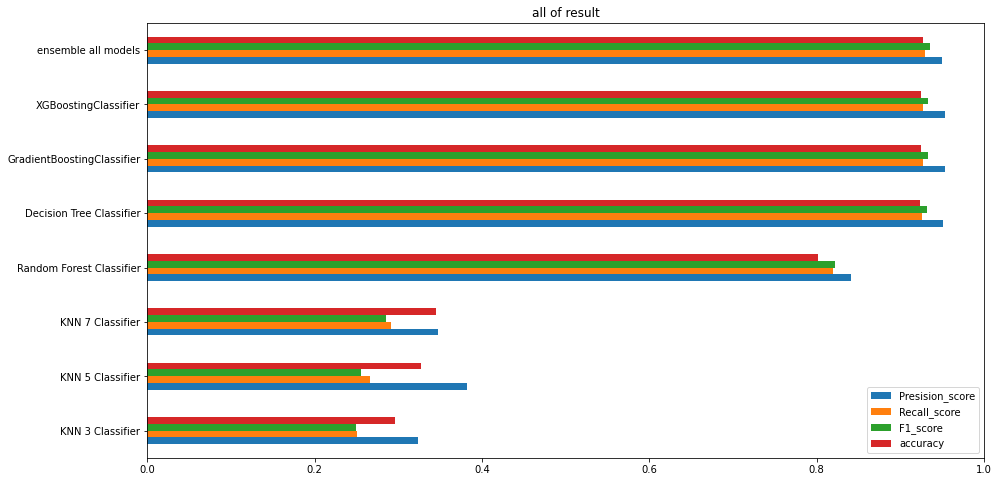

In [77]:
result.plot.barh(title='all of result',figsize=(15,8))